# <span style='color:SteelBlue'>P6 - Classifiez automatiquement des biens de consommation (part 1)</span>

<img src="https://user.oc-static.com/upload/2019/02/24/15510259240381_Projet%20textimage%20logo.png" width="600" height="400">

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies<br>

Paramètres d'affichage<br>

Fonctions <br>

Importation des donnees <br>

**Etape 1 : Description des donnees**
- _1/ etc..._


Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise **"place de marché"** est une entreprise qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits) 
la plus fluide possible, et dans l'optique d'un passage à l'échelle, 
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un 
article (actuellement effectuée manuellement par les vendeurs, donc peu 
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une image et une description pour automatiser l’attribution
de catégorie de l’article. 

2/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle. 

3/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 1ère partie concernant la faisabilité d'un moteur de
classification. Nous allons donc analyser les descriptions textuelles
des produits en réalisant :
-	1 prétraitement des données texte ou image suivant le cas.
-	1 extraction des features par différentes méthodes :
    - Pour les données textuelles :
      - 2 approches de type “bag-of-words” avec comptage simple de mots et Tf-idf
      - 1 approche de type word/sentence embedding classique avec Word2Vec
      - 1 approche de type word/sentence embedding avec BERT
      - 1 approche de type word/sentence embedding avec USE
    - Pour les données images :
      - 1 algorithme de type SIFT/ ORB / SURF
      - 1 algorithme de type CNN Transfer Learning
-	1 réduction en 2 dimensions, afin de projeter les produits sur un
    graphique 2D, sous la forme de points dont la couleur correspondra à la
    catégorie réelle
-	1 analyse graphique pour déduire la faisabilité de regroupement
    automatique. 
-	1 calcul de similarité entre les catégories réelles et les catégories
issues d’une segmentation en clusters pour confirmer notre analyse visuelle.
___
**Source des datasets**<br>
Source : Non précisé<br>
___

<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le
terminal VSC : </b><br>
nbqa black Berthe_Pierrick_1_notebook_exploration_112023.ipynb</div>

# <span style='background:grey'>Importations des librairies</span>

In [215]:
# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# machine learning
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.preprocessing import LabelEncoder

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import words
import string


# Word2Vec
import gensim
import tensorflow as tf
import multiprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# BERT & USE
from transformers import AutoTokenizer, TFAutoModel
import tensorflow_hub as hub

# Bibliotheque stopwords NLTK
nltk.download('stopwords')

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Gensim        : " + gensim.__version__)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Sklearn       : " + sklearn.__version__)
print("Tensorflow    : " + tf.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"\nNombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Version des librairies utilisees :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Gensim        : 4.3.2
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Seaborn       : 0.13.0
Sklearn       : 1.3.2
Tensorflow    : 2.15.0

Nombre de coeur disponible(s) sur ce PC: 12 coeur(s)

Code lance le : 2024-01-14T21:44:07.279536

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pierr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le 
terminal VSC : </b> <br>
nbqa black nom_fichier.ipynb</div>

# <span style='background:grey'>Paramètres d'affichage</span>

In [216]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# <span style='background:grey'>Fonctions</span>


In [217]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """

    # Calculer la durée totale
    total_time = time.time() - start_time

    # Convertir en minutes et secondes
    minutes, seconds = divmod(total_time, 60)

    # Afficher la durée totale
    message = (
        "Durée totale pour faire tourner le notebook : "
        "{0} minute(s) {1} seconde(s)"
    )
    print(message.format(int(minutes), int(seconds)))

In [218]:
def affiche_sample(sub_df, n_samp=10):
    """
    Affiche n_samp documents d'un corpus.

    Paramètres:
    sub_df (pandas.DataFrame): Le DataFrame contenant le corpus de documents.
    n_samp (int, optional): Le nombre de documents à afficher. Par défaut à 10.

    Retours:
    None
    """

    # Sélectionne n_samp documents aléatoirement
    samp = sub_df.sample(n_samp)

    # Affiche les n_samp documents
    for idx, ser in samp.iterrows():
        txt_1 = f"==> product_name : {ser['product_name']}<==\n"
        print(txt_1 + ser['description'] + "..." + "\n\n")

In [219]:
def nettoyage_de_base_pour_texte(text):
    """
    Prétraite une chaîne de caractères en effectuant les opérations suivantes :
    - Conversion en minuscules
    - Suppression de la ponctuation
    - Suppression des espaces de plus d'un espace

    Args:
        text (str): La chaîne de caractères à prétraiter.

    Returns:
        str: La chaîne de caractères prétraitée.
    """
    # Convertir le texte en minuscules
    text = text.lower()

    # Supprimer la ponctuation
    text = "".join([char for char in text if char not in string.punctuation])

    # Supprimer les espaces de plus d'un espace
    text = " ".join(text.split())

    return text

In [220]:
def afficher_document_temoin(
        df_text,
        df_text_clean,
        text,
        numero_document_temoin):
    """
    Fonction qui affiche un document avant et après le nettoyage.

    Paramètres:
    df_text (pandas.DataFrame): DataFrame contenant les documents avant le
    nettoyage.
    df_text_clean (pandas.DataFrame): DataFrame contenant les documents après
    le nettoyage.
    text (str): Texte à afficher.
    numero_document_temoin (int): Numéro du document témoin à afficher.

    Retourne:
    None
    """
    # Document témoin
    doc_temoin_avant = df_text["description"][numero_document_temoin]
    doc_temoin_apres = df_text_clean["description"][numero_document_temoin]

    # Affichage AVANT
    print(f"AVANT {text} : ")
    print(doc_temoin_avant)

    # Affichage APRES
    print(f"APRES {text} : ")
    print(doc_temoin_apres)

In [221]:
def afficher_tsne(feat_tsne_df, titre):
    """
    Affiche un scatterplot des résultats t-SNE.

    Paramètres
    ----------
    feat_tsne_df : DataFrame
        Un DataFrame contenant les résultats t-SNE et les classes
        correspondantes.
        Il doit contenir les colonnes 'tsne1', 'tsne2' et 'class'.
    titre : str
        Le titre du graphique.

    Retourne
    -------
    None
    """
    # Création de la figure
    plt.figure(figsize=(12, 8))

    # Affichage des points
    sns.scatterplot(
        x="tsne1",
        y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
        data=feat_tsne_df,
        legend="brief")

    # titre et axes
    plt.title(titre, fontsize=30, pad=35, fontweight='bold')
    plt.xlabel('tsne1', fontsize=26, fontweight='bold')
    plt.ylabel('tsne2', fontsize=26, fontweight='bold')

    plt.show()

In [222]:
def calcul_t_nse_et_clusters(X, labels_reel):
    """
    Calcule une transformation t-SNE des données et effectue un clustering
    KMeans sur le résultat.
    Mesure également le temps d'exécution et calcule l'indice de Rand ajusté
    (ARI).

    Paramètres:
    X : array-like, shape (n_samples, n_features)
        Les données à transformer et à regrouper.
    labels_reel : array-like, shape (n_samples,)
        Les vraies catégories de chaque point.

    Retourne:
    ARI : float
        L'indice de Rand ajusté, une mesure de la qualité du clustering.
    X_tsne : array-like, shape (n_samples, n_components)
        Les données transformées par t-SNE.
    cls.labels_ : array-like, shape (n_samples,)
        Les clusters attribués à chaque point par KMeans.
    """

    # Lance le timer
    time1 = time.time()

    # t-NSE
    tsne = manifold.TSNE(
        n_components=2,
        perplexity=30,
        init='random',
        learning_rate=200,
        random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)

    # Calcul de l'indice de Rand ajusté
    ARI = np.round(metrics.adjusted_rand_score(labels_reel, cls.labels_), 3)

    # Temps d'exécution
    time2 = np.round(time.time() - time1, 0)
    print("Temps t-NSE + cluster : ", time2, "sec")

    return (ARI, X_tsne, cls.labels_)

In [223]:
def comparatif_t_nse_clusters(X_tsne, labels_reel, cls_labels, ARI):
    """
    Visualise les données en utilisant t-SNE, en colorant les points selon
    les vraies catégories et les clusters.

    Paramètres:
    X_tsne : array-like, shape (n_samples, n_components)
        Les données à visualiser, transformées par t-SNE.
    labels_reel : array-like, shape (n_samples,)
        Les vraies catégories de chaque point.
    cls_labels : array-like, shape (n_samples,)
        Les clusters attribués à chaque point.
    ARI : float
        L'indice de Rand ajusté, une mesure de la qualité du clustering.

    Retourne:
    None
    """

    # LabelEncoder aux labels et transformer les labels
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels_reel)

    # Nom des categories
    labels_unique = labels_reel.unique()

    # Création de la figure
    fig = plt.figure(figsize=(15, 6))

    # plot des vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=labels_encoded,
        cmap='Set1'
        )
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(labels_unique),
        loc="best",
        title="Categorie"
        )
    plt.title('Représentation t-NSE par catégories réelles')

    # plot des clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(
        X_tsne[:, 0],
        X_tsne[:, 1],
        c=cls_labels,
        cmap='Set1'
        )
    ax.legend(
        handles=scatter.legend_elements()[0],
        labels=set(cls_labels),
        loc="best",
        title="Clusters"
        )
    plt.title('Représentation t-NSE par clusters')

    # Affichage de l'ARI
    plt.show()
    print("ARI : ", ARI)

In [224]:
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """
    Prépare les entrées pour le modèle BERT à partir d'une liste de phrases.

    Args:
        sentences (list): Liste de phrases à traiter.
        bert_tokenizer (BertTokenizer): Tokenizer BERT à utiliser.
        max_length (int): Longueur maximale des séquences.

    Returns:
        tuple: Un tuple contenant les identifiants d'entrée, les identifiants
        de type de token, les masques d'attention et les entrées totales de
        BERT.
    """
    # Initialisation des listes pour stocker les résultats
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    # Parcourir toutes les phrases
    for sent in sentences:

        # Encoder chaque phrase avec le tokenizer BERT
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=True,
            truncation=True,
            return_tensors="tf"
            )

        # Ajouter les résultats à nos listes
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                            bert_inp['token_type_ids'][0],
                            bert_inp['attention_mask'][0]))

    # Convertir les listes en arrays numpy
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot

In [225]:
%pycodestyle_off
def feature_BERT_fct(
        model,
        model_type,
        sentences,
        max_length,
        b_size,
        mode='HF'
        ):
    """
    Crée des features à partir d'un modèle BERT pour une liste de phrases.

    Args:
        model (tf.Model): Modèle BERT à utiliser.
        model_type (str): Type du modèle BERT.
        sentences (list): Liste de phrases à traiter.
        max_length (int): Longueur maximale des séquences.
        b_size (int): Taille du batch.
        mode (str, optional): Mode de fonctionnement ('HF' pour HuggingFace,
        'TFhub' pour TensorFlow Hub). Par défaut à 'HF'.

    Returns:
        tuple: Un tuple contenant les features BERT et les derniers états
        cachés.
    """
    # Initialisation des paramètres
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    # Parcourir toutes les phrases par batch
    for step in range(len(sentences)//batch_size):
        idx = step * batch_size

        # Préparer les entrées pour le modèle BERT
        input_ids, token_type_ids, attention_mask, bert_inp_tot = \
            bert_inp_fct(
                sentences[idx : idx + batch_size],
                bert_tokenizer,
                max_length
                )
        
        # Prédire avec le modèle BERT HuggingFace
        if mode=='HF':
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids],
                batch_size=batch_size_pred
                )
            last_hidden_states = outputs.last_hidden_state

        # Prédire avec le modèle BERT Tensorflow Hub
        if mode=='TFhub':
            text_preprocessed = {
                "input_word_ids" : input_ids,
                "input_mask" : attention_mask,
                "input_type_ids" : token_type_ids
                }
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        # Stocker les derniers états cachés
        if step ==0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((
                last_hidden_states_tot,
                last_hidden_states
                ))
    
    # Calculer les features BERT
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    # Temps d'exécution
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot
%pycodestyle_on

In [322]:
def feature_USE_fct(sentences, b_size, embed):
    """
    Cette fonction génère des caractéristiques à partir d'un modèle Universal
    Sentence Encoder (USE)
    pour une liste de phrases.

    Args:
    sentences (list): Une liste de phrases pour lesquelles générer des
    caractéristiques.
    b_size (int): La taille des lots pour le traitement des données.
    embed (tensorflow_hub.KerasLayer): Le modèle USE à utiliser.

    Returns:
    numpy.ndarray: Les caractéristiques générées par le modèle USE pour
    chaque phrase.
    """
    # Définir la taille du lot
    batch_size = b_size

    # Enregistrer le temps de début
    time1 = time.time()

    # Boucle sur les lots de phrases
    for step in range(len(sentences) // batch_size):

        # Calculer l'index de début du lot
        idx = step * batch_size

        # Générer des caractéristiques pour le lot de phrases
        feat = embed(sentences[idx:idx + batch_size])

        # Concatener les nouvelles caractéristiques aux anciennes
        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    # Calculer le temps écoule
    time2 = np.round(time.time() - time1, 0)
    print("temps traitement USE : ", time2)

    return features

# <span style='background:grey'>Importation des donnees</span>

Importation des fichiers CSV avec Pandas

In [227]:
# Definir le chemin
chemin = "./data/source/"

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
data_brut = {}
display("===> Liste des fichiers importes: <====\n")

# POUR chaque fichier
for fichier in fichiers:

    # Traiter uniquement les fichiers .csv
    if fichier.endswith(".csv"):
        display(fichier)

        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(
            chemin + fichier,
            sep=",",
            encoding="utf-8"
        )

'===> Liste des fichiers importes: <====\n'

'flipkart_com-ecommerce_sample_1050.csv'

# <span style='background:blue'>Etape 1 : Présentation du dataset</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons le début, la fin et des échnatillons au hasard du tableau.

In [228]:
fichier = data_brut["flipkart_com-ecommerce_sample_1050.csv"]
fichier.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [229]:
fichier.tail(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


In [230]:
fichier.sample(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
501,2e474c49a7dfe704c35cf3990740daa3,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-8959yl01-yuva-g...,Sonata 8959YL01 Yuva Gold Analog Watch - For ...,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATDA5ZAGNMGD5EJ,780.0,780.0,2e474c49a7dfe704c35cf3990740daa3.jpg,False,Sonata 8959YL01 Yuva Gold Analog Watch - For ...,4.1,4.1,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
970,3e2b2a04696f7d83a7835e9894d79df7,2016-05-26 12:20:35 +0000,http://www.flipkart.com/bela-home-cotton-carto...,Bela Home Cotton Cartoon Single Bedsheet,"[""Baby Care >> Baby Bedding >> Baby Bedsheets ...",BDSEGZCDGH2PU6YZ,599.0,319.0,3e2b2a04696f7d83a7835e9894d79df7.jpg,False,Key Features of Bela Home Cotton Cartoon Singl...,No rating available,No rating available,Bela Home,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
46,3388d05e88972ff9f3e1321dc0cfdc28,2016-03-20 14:44:44 +0000,http://www.flipkart.com/akup-keep-calm-ceramic...,AKUP keep-calm Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> AKUP Coff...",MUGEGZUMNZCKBZYS,500.0,259.0,3388d05e88972ff9f3e1321dc0cfdc28.jpg,False,Key Features of AKUP keep-calm Ceramic Mug Pac...,No rating available,No rating available,AKUP,"{""product_specification""=>[{""key""=>""Type"", ""va..."


Informations sur les features :
- **uniq_id** : identifiant unique du produit
- **crawl_timestamp** :  date de récupération des données
- **product_url** : url du produit 
- **product_name** : nom du produit
- **product_category_tree** : Arborescence pour
    atteindre la catégorie du produit
- **pid** : identifiant de processus ou identifiant perenne
- **retail_price** : prix de vente (monnaie inconnue)
- **discounted_price** : prix de vente avec remise
    (monnaie inconnue)
- **image** : nom du fichier JPEG de l'image du produit
- **is_FK_Advantage_product** : produit avantageux Flipkart (Oui/Non)
- **description** : description du produit
- **product_rating** : note du produit
- **overall_rating** : note globale
- **brand** : marque du produit
- **product_specifications** : spécifications du produit

## <span style='background:green'>2/ Structure</span>

Nous affichons la structure du tableau. Nous comptons également le nombre de
features par type et le nombre de valeurs uniques par feature. 

In [231]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [232]:
fichier.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [233]:
tmp = fichier.nunique()
tmp

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

Le fichier contient 1_050 lignes et 15 colonnes. Il y a une majorité de données de type object (12/15). Pour autant, il y a 3 features qui ne sont pas dans le format attendu :
- **crawl_timestamp** : format object au lieu de datetime
- **product_rating** : format object au lieu de int/float
- **overall_rating** : format object au lieu de int/float

## <span style='background:green'>3/ Valeurs manquantes</span>

In [234]:
fichier.isna().sum().sort_values(ascending=False)

brand                      338
retail_price                 1
discounted_price             1
product_specifications       1
uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
dtype: int64

In [235]:
missing_values = fichier.isna().mean()
columns_with_na = missing_values[missing_values > 0].sort_values(
    ascending=False)
display(columns_with_na)

brand                     3.22e-01
retail_price              9.52e-04
discounted_price          9.52e-04
product_specifications    9.52e-04
dtype: float64

Il y a 1 valeur manquante dans les features "retail_price", 
"discounted_price", "product_specifications".

Il y a 338 valeurs (1/3) manquantes dans les features "brand".

## <span style='background:green'>4/ Doublons</span>

Nous vérifions tout d'abord qu'il n'y a pas 2 lignes doublons. Puis nous observons les valeurs doublons par feature. 

In [236]:
fichier.duplicated().sum()

0

In [237]:
for col in fichier.columns:
    n = fichier.duplicated(subset=[col]).sum()
    print(f"col : {col} -> duplicated : {n}")

col : uniq_id -> duplicated : 0
col : crawl_timestamp -> duplicated : 901
col : product_url -> duplicated : 0
col : product_name -> duplicated : 0
col : product_category_tree -> duplicated : 408
col : pid -> duplicated : 0
col : retail_price -> duplicated : 695
col : discounted_price -> duplicated : 625
col : image -> duplicated : 0
col : is_FK_Advantage_product -> duplicated : 1048
col : description -> duplicated : 0
col : product_rating -> duplicated : 1023
col : overall_rating -> duplicated : 1023
col : brand -> duplicated : 559
col : product_specifications -> duplicated : 65


Il n'y a pas de ligne doublons. En revanche, il y a des valeurs doublons dans plusieurs features. 

## <span style='background:green'>5/ Inspection des données</span>

Resume des features **quantitatives** :

In [238]:
fichier.describe().round(2)

,retail_price,discounted_price
count,1049.00,1049.00
mean,2186.20,1584.53
std,7639.23,7475.10
min,35.00,35.00
25%,555.00,340.00
50%,999.00,600.00
75%,1999.00,1199.00
max,201000.00,201000.00


Resume des features **qualitatives** : 

In [239]:
fichier.describe(exclude=[np.number, "datetime64[ns]"])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,2,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,993,1,889,889,11,22


## <span style='background:green'>6/ Autorisation d'utilisation</span>

Notre client nous a confirmé que les textes et les images sont libres de droit.
Ils peuvent être utilisés et modifiés pour sans aucune contrainte de proriété
intellectuelle.

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'flipkart_com-ecommerce_sample_1050'** contient 15 features 
concernant 1_050 produits vendus sur le site de e-commerce Flipkart.com.
Les textes et images sont libres de droit.

Les données timestamp ne sont pas dans un format de datetime standard.<br>
Les données de score ne sont pas dans un format de nombre (str ou float).<br>
Il manque le prix d'1 produit et le nom de la marque de 338 produits.<br>

# <span style='background:blue'>Etape 2 : Extraction des features textes</span>

## <span style='background:green'>1/ Nettoyage</span>

### <span style='background:black'>a/ Sélection des features</span>

Voici la feature qui contient une description du produit.

In [240]:
fichier["description"]

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

Voici la feature qui contient la catégorie du produit.

In [241]:
fichier["product_category_tree"]

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

Nous créons un nouveau dataframe avec ces 2 features précédentes.

In [242]:
cols = ["description", "product_category_tree"]
data_raw = fichier[cols]
data_raw.head()

,description,product_category_tree
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


### <span style='background:black'>b/ Détermination de la catégorie du produit</span>

Nous splittons la feature "product_category_tree" pour obtenir uniquement la catégorie principale du produit dans la feature "target".

In [243]:
data_raw.loc[:, 'product_name'] = \
    data_raw.loc[:, 'product_category_tree'].str.split(
        '>>').str[0].str.lstrip('["')
data_raw.head(3)

C:\Users\pierr\AppData\Local\Temp\ipykernel_6212\2766752290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw.loc[:, 'product_name'] = \


,description,product_category_tree,product_name
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care


Nous supprimons la feature "product_category_tree" qui ne nous sert plus. 

In [244]:
df_text = data_raw.copy()
df_text.drop("product_category_tree", axis=1, inplace=True)
df_text.head(3)

,description,product_name
0,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care


### <span style='background:black'>c/ Vérification Nan</span>

Nous vérifions qu'il n'y a aucun Nan dans le dataframe.

In [245]:
df_text.isna().sum()

description     0
product_name    0
dtype: int64

### <span style='background:black'>d/ Vérification doublons</span>

Nous vérifions qu'il n'y a aucun doublon dans le dataframe.

In [246]:
idx = df_text.duplicated(subset="description", keep="first")
idx.sum()

0

## <span style='background:green'>2/ EDA</span>

### <span style='background:black'>a/ Product_name</span>

In [247]:
df_text.product_name.value_counts(normalize=False)

product_name
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

<Axes: ylabel='count'>

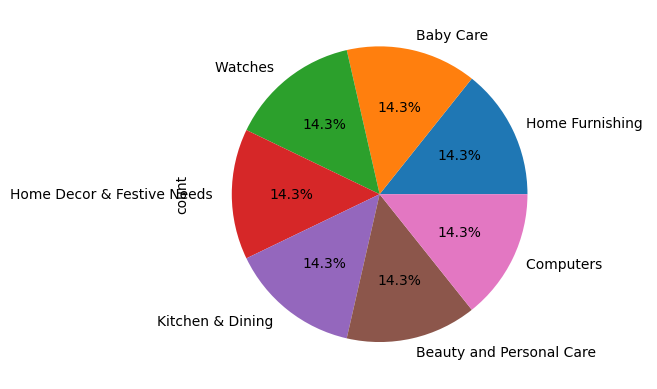

In [248]:
df_text.product_name.value_counts().plot(kind="pie", autopct='%1.1f%%')

La feature "product_name" comprend 7 catégories de produits qui sont toutes réparties équitablement dans le dataframe avec 150 produits par catégorie.

### <span style='background:black'>b/Longueur des documents</span>

Nous observons la longueur des documents en nombre de mots.

In [249]:
df_text.description.describe()

count                                                  1050
unique                                                 1050
top       Key Features of Elegance Polyester Multicolor ...
freq                                                      1
Name: description, dtype: object

In [250]:
tmp = df_text.description.str.len()
tmp

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

<Axes: xlabel='description'>

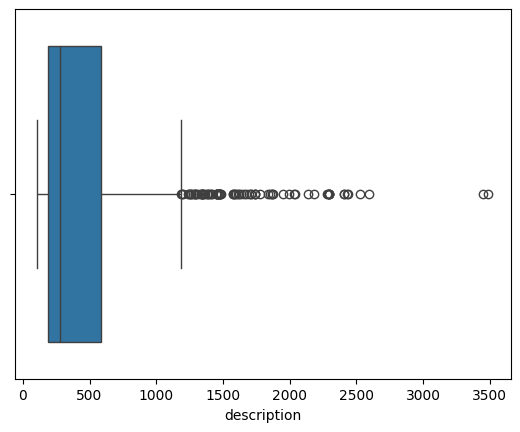

In [251]:
tmp.describe()
sns.boxplot(tmp, orient="h")

<Axes: xlabel='description', ylabel='Count'>

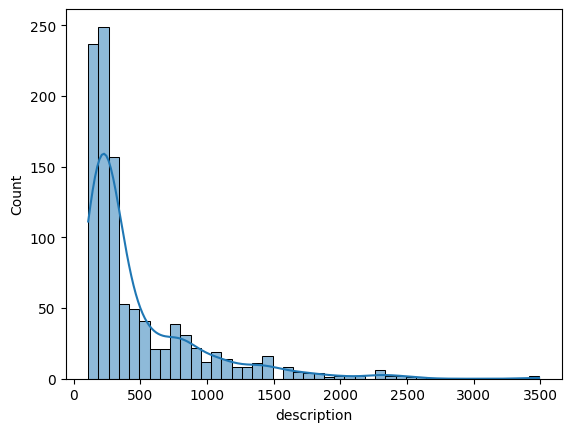

In [252]:
sns.histplot(tmp, kde=True)

Les descriptions sont comprises entre 100 et 3_500 caractères. La majorité des descriptions sont comprises entre 100 et 400 caractères.

### <span style='background:black'>c/Exploration corpus et documents</span>

Nous explorons des documents au hasard.

In [253]:
df_samp = df_text.sample(10, random_state=42)
df_samp

,description,product_name
352,Buy Zyxel PLA-4205 only for Rs. 8100 from Flip...,Computers
689,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb f...,Kitchen & Dining
485,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,Computers
388,Flipkart.com: Buy Anna Andre Paris Set of Dark...,Beauty and Personal Care
31,"Lenco Bdblue Tango Analog Watch - For Men, Bo...",Watches
442,Key Features of Rute Baby Girl's Sleepsuit Fab...,Baby Care
198,Surface180 Wonderful Wooden Antique Drawer Box...,Home Decor & Festive Needs
425,Specifications of Zingalalaa LP-50 50 lm LED C...,Computers
107,Artisan Creation Checkered Single Quilts & Com...,Home Furnishing
714,"Buy Home Originals Abstract, Checkered Double ...",Home Furnishing


In [254]:
affiche_sample(df_samp)

==> product_name : Computers <==
Buy Zyxel PLA-4205 only for Rs. 8100 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


==> product_name : Watches <==
Lenco Bdblue Tango Analog Watch  - For Men, Boys - Buy Lenco Bdblue Tango Analog Watch  - For Men, Boys  Bdblue Online at Rs.599 in India Only at Flipkart.com. Sports Watch, Casual Watch, Big Size Dial, Colourful Strap - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


==> product_name : Home Furnishing <==
Artisan Creation Checkered Single Quilts & Comforters Brown (1 Single Bed Quilt)
                         Price: Rs. 745
				
			Presenting The World Famous Jaipuri Pure Cotton And Velvet Single Bed Razai (Quilt) in Traditional Sanganeri Print of Rajasthan. These Good Looking, Fluffy, Handmade Indian Quilts Are a Specialty of Jaipur. This Spectacular Quilt Will Enhance The Beauty of your Home Decor.Specially designed 

Nous explorons le corpus selon les catégories de "product_name".

In [255]:
# Afficher les différentes catégories
unique_product_name = df_text['product_name'].unique()
display(unique_product_name)

# Créer un dataframe par catégorie
dfs = {}
for product_name in unique_product_name:
    dfs[product_name] = df_text[df_text['product_name'] == product_name]

array(['Home Furnishing ', 'Baby Care ', 'Watches ',
       'Home Decor & Festive Needs ', 'Kitchen & Dining ',
       'Beauty and Personal Care ', 'Computers '], dtype=object)

In [256]:
affiche_sample(dfs[unique_product_name[0]], n_samp=5)

==> product_name : Home Furnishing <==
Buy Raymond Abstract Double Blanket Grey at Rs. 8999 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


==> product_name : Home Furnishing <==
Buy Indigocart Plain Double Dohar Grey at Rs. 1015 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


==> product_name : Home Furnishing <==
Buy Home Originals Abstract, Abstract Double Blanket Multicolor at Rs. 1299 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


==> product_name : Home Furnishing <==
Buy Raymond Abstract Double Blanket Blue at Rs. 4999 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!...


==> product_name : Home Furnishing <==
Just Linen Cotton Bath Towel (2 Terry Bath Towels, Lilac and Orange)
                         Price: Rs. 1,052
				
			Plain and Simple does the trick! This Classic Super Soft and Very Heavy Bath Towel has terry loop threads all over with thick ribbed horizont

In [257]:
affiche_sample(dfs[unique_product_name[1]], n_samp=5)

==> product_name : Baby Care <==
Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,Specifications of Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Bath Towel Features Material Cotton Terry Design SHUVAM General Brand Eurospa GSM

In [258]:
affiche_sample(dfs[unique_product_name[2]], n_samp=5)

==> product_name : Watches <==
Disney 98189 Analog Watch  - For Boys, Girls - Buy Disney 98189 Analog Watch  - For Boys, Girls  98189 Online at Rs.900 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


==> product_name : Watches <==
Maxima 20981LMGI Attivo Analog Watch  - For Men - Buy Maxima 20981LMGI Attivo Analog Watch  - For Men  20981LMGI Online at Rs.895 in India Only at Flipkart.com. Round Dial, Buckle Clasp, Black Strap, Brass Case, Water Resistant - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


==> product_name : Watches <==
Times 284TMS284 Party-Wedding Analog Watch  - For Women - Buy Times 284TMS284 Party-Wedding Analog Watch  - For Women  284TMS284 Online at Rs.550 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


==> product_name : Wa

In [259]:
affiche_sample(dfs[unique_product_name[3]], n_samp=5)

==> product_name : Home Decor & Festive Needs <==
Buy Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm for Rs.21800 online. Exotic India Adi Buddha Vajrasattva Showpiece  -  27.94 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


==> product_name : Home Decor & Festive Needs <==
Buy Golmaalshop Showpiece  -  27.9 cm for Rs.799 online. Golmaalshop Showpiece  -  27.9 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


==> product_name : Home Decor & Festive Needs <==
Buy The Ethnic Story Royal Durban Showpiece  -  30.48 cm for Rs.1850 online. The Ethnic Story Royal Durban Showpiece  -  30.48 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee....


==> product_name : Home Decor & Festive Needs <==
Home Delight 130 inch Pink Rice Lights (Pack of 5)
                         Price: Rs. 199
				
			T

In [260]:
affiche_sample(dfs[unique_product_name[4]], n_samp=5)

==> product_name : Kitchen & Dining <==
Pristine Hard Anodised Kadhai 2 L (Aluminium)
                         Price: Rs. 899
				
			PRISTINE, Manufacturers of a range of Gourmet Cookware carries an experience of over two decades & has been successfully exporting to The Americas, Europe, Australia. The organization is ISO Certified having state of the art manufacturing facility spread over an area of 1,50,000 sq.feet.All products are manufactured with precise workmanship & pass through stringent quality control tests & checks. We deliver Quality products to our customers at factory prices. All products are packed in attractive gift boxes making it an ideal gifting solution as well.Our efforts are towards making the Kitchen a smarter place enhancing convenience, reduce time spent & reflect modern lifestyles.Our Mission: �To provide Quality Products at Affordable Prices.�
PRISTINE, Manufacturers of a range of Gourmet Cookware carries an experience of over two decades & has been successf

In [261]:
affiche_sample(dfs[unique_product_name[5]], n_samp=5)

==> product_name : Beauty and Personal Care <==
Flipkart.com: Buy Wild Stone Smoke And Juice Combo Set online only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


==> product_name : Beauty and Personal Care <==
Oxyglow Lacto Bleach & Fruit Massage Cream With Vitamin-E (Set of 2)
                         Price: Rs. 594
				
			OxyGlow brings to you a one stop solution to your beauty and cosmetics products catering to all your needs through its wide range of beauty care products like face wash, bleach, face pack, oils, lotions, gels, conditioners, lip and eye care products and many more. So beat your beauty problems with the help of Oxy Glow’s range of beauty products at your ease by ordering them immediately!
OxyGlow brings to you a one stop solution to your beauty and cosmetics products catering to all your needs through its wide range of beauty care products like face wash, bleach, face pack, oils, lotions, gels

In [262]:
affiche_sample(dfs[unique_product_name[6]], n_samp=5)

==> product_name : Computers <==
Techone+ Flexible SE122103-GREEN USB Led Light (Green)
                         Price: Rs. 449
				
			Usable with Power Bank, Laptop, USB Port Adaptor, USB Multi Pin Board & USB Port Device.
Usable with Power Bank, Laptop, USB Port Adaptor, USB Multi Pin Board & USB Port Device....


==> product_name : Computers <==
Buy Tenda 3G300M only for Rs. 3000 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


==> product_name : Computers <==
Buy Zyxel 3D 1440 - 3G Data Card only for Rs. 950 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!...


==> product_name : Computers <==
Specifications of HP v220w 16 GB  Pen Drive (Silver, Black) General Specifications Interface USB 2.0 Brand HP Capacity (GB) 16 GB Model v220w Case Material Metal Color Silver, Black Dimensions Weight 4.5 g In the Box 1 Pendrive...


==> product_name : Computers <==
Buy Linksys

Nous remarquons qu'il y a des mots propres à chaque catégorie. Par exemple :
- Home Furnishing : sofa, floral, , ...
- Baby care : baby, cotton, ...
- Watches : watch, analog, ...
- Home Decor & Festive Needs : statues, decorative, ...
- Kitchen & Dining : ceramic, mug, ...
- Beauty and Personal Care : cream, massage, ...

A noter que certains mots sont bien entendus présents dans plusieurs catégories.
Nous allons donc devoir faire un nettoyage des données pour supprimer les mots qui ne sont pas pertinents pour la catégorisation.

## <span style='background:green'>3/ pré-traitement</span>

### <span style='background:black'>a/ Nettoyage de base</span>

Nous effectuons un nettoyage de base sur les données textuelles, à savoir :
- Uniformisation de la casse en minuscule
- Suppression de la ponctuaction
- Suppression des espaces inutiles

In [263]:
# Copier le dataframe
df_text_clean = df_text.copy()

# Appliquer la fonction de nettoyage
df_text_clean['description'] = df_text['description'].apply(
    nettoyage_de_base_pour_texte)
df_text_clean['product_name'] = df_text['product_name'].apply(
    nettoyage_de_base_pour_texte)

# Affichage aperçu
df_text_clean.head()

,description,product_name
0,key features of elegance polyester multicolor ...,home furnishing
1,specifications of sathiyas cotton bath towel 3...,baby care
2,key features of eurospa cotton terry face towe...,baby care
3,key features of santosh royal fashion cotton p...,home furnishing
4,key features of jaipur print cotton floral kin...,home furnishing


Nous affichons un document témoin avant et après nettoyage pour vérification.

In [264]:
# Numero du document témoin
numero_document_temoin = 5

# Afficher le comparatif
afficher_document_temoin(
    df_text, df_text_clean, "nettoyage de base", numero_document_temoin)

AVANT nettoyage de base : 
Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
APRES nettoyage de base : 
maserati time r8851116001 analog watch for boys buy maserati time r8851116001 analog watch for boys r8851116001 online at rs24400 in india only at flipkartcom great discounts only genuine products 30 day replacement guarantee free shipping cash on delivery


### <span style='background:black'>b/ Tokenisation</span>

Nous séparons chaque document en une liste de mots (tokens).

In [265]:
# copier le dataframe
df_text_token = df_text_clean.copy()

# Appliquer la fonction nltk.word_tokenize
df_text_token['description'] = df_text_clean['description'].apply(
    nltk.word_tokenize)

# Agglomérer tous les tokens de la colonne 'description'
corpus = [token for doc in df_text_token['description'] for token in doc] + \
    [token for doc in df_text_token['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_token.head())

'nb tokens 93470, nb unique tokens 6684'

,description,product_name
0,"[key, features, of, elegance, polyester, multi...",home furnishing
1,"[specifications, of, sathiyas, cotton, bath, t...",baby care
2,"[key, features, of, eurospa, cotton, terry, fa...",baby care
3,"[key, features, of, santosh, royal, fashion, c...",home furnishing
4,"[key, features, of, jaipur, print, cotton, flo...",home furnishing


Nous affichons un document témoin avant et après tokenisation pour vérification.

In [266]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_clean, df_text_token, "tokenisation", numero_document_temoin)

AVANT tokenisation : 
maserati time r8851116001 analog watch for boys buy maserati time r8851116001 analog watch for boys r8851116001 online at rs24400 in india only at flipkartcom great discounts only genuine products 30 day replacement guarantee free shipping cash on delivery
APRES tokenisation : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'buy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'r8851116001', 'online', 'at', 'rs24400', 'in', 'india', 'only', 'at', 'flipkartcom', 'great', 'discounts', 'only', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']


### <span style='background:black'>c/ Stopwords</span>

Nous supprimons les stopwords (mots sans intérêts) qui ne sont pas pertinents pour la catégorisation.

In [267]:
# copier le dataframe
df_text_sw = df_text_token.copy()

# Charger les stopwords anglais
stop_words = set(stopwords.words("english"))

# Supprimer les stopwords anglais
df_text_sw['description'] = df_text_token['description'].apply(
    lambda doc: [w for w in doc if w not in stop_words])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_sw['description'] for token in doc] + \
    [token for doc in df_text_token['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_sw.head())

'nb tokens 74399, nb unique tokens 6573'

,description,product_name
0,"[key, features, elegance, polyester, multicolo...",home furnishing
1,"[specifications, sathiyas, cotton, bath, towel...",baby care
2,"[key, features, eurospa, cotton, terry, face, ...",baby care
3,"[key, features, santosh, royal, fashion, cotto...",home furnishing
4,"[key, features, jaipur, print, cotton, floral,...",home furnishing


Nous affichons un document témoin avant et après la suppression des stopwords pour vérification.

In [268]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_token,
    df_text_sw,
    "nettoyage des stopwords",
    numero_document_temoin)

AVANT nettoyage des stopwords : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'buy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'for', 'boys', 'r8851116001', 'online', 'at', 'rs24400', 'in', 'india', 'only', 'at', 'flipkartcom', 'great', 'discounts', 'only', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'on', 'delivery']
APRES nettoyage des stopwords : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'buy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'india', 'flipkartcom', 'great', 'discounts', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']


### <span style='background:black'>d/ Token omniprésent</span>

Nous comptons le nombre d'occurence de chaque token dans chaque catégorie. 

In [269]:
# dictionnaire des comptages des tokens par catégorie vide
value_counts_cate = {}

# Pour chaque valeur de la feature 'product_name'
for product_name_value in df_text_sw['product_name'].unique():

    # Sélectionner les documents de la catégorie
    df_cate = df_text_sw[
        df_text_sw['product_name'] == product_name_value
        ]['description']

    # Agglomérer tous les tokens de la catégorie
    corpus_par_cate = [token for doc in df_cate for token in doc]

    # Compter les occurences des tokens de la catégorie
    value_counts_cate[product_name_value] = pd.Series(
        corpus_par_cate).value_counts()

    # Afficher le comptage des tokens et aperçu
    print(f"\nValeur de la cible : {product_name_value}")
    print(value_counts_cate[product_name_value])


Valeur de la cible : home furnishing
cm         167
rs         128
cotton      99
pack        88
cover       83
          ... 
form         1
tuft         1
needle       1
removed      1
ac771        1
Name: count, Length: 1179, dtype: int64

Valeur de la cible : baby care
baby        313
girls       194
cotton      182
details     174
fabric      162
           ... 
chlorine      1
promptly      1
11000026      1
5099          1
rs595         1
Name: count, Length: 1596, dtype: int64

Valeur de la cible : watches
watch        324
analog       249
men          158
day          136
discounts    134
            ... 
rs399          1
rs201000       1
rs593          1
rs770          1
pack           1
Name: count, Length: 708, dtype: int64

Valeur de la cible : home decor festive needs
cm             277
showpiece      204
1               92
products        92
best            87
              ... 
throughview      1
entrances        1
doors            1
premises         1
685             

Nous supprimons les tokens qui sont présents dans toutes les catégories.

In [270]:
# Séparer les tokens présents dans chaque les catégories
token_cate = [
    set(value_counts[value_counts >= 1].index)
    for value_counts in value_counts_cate.values()
]

# Sélectionner les tokens présents dans toutes les catégories
token_omni = set.intersection(*token_cate)

print(
    "Nombre de token(s) présent(s) dans toutes les categories",
    len(token_omni),
    "\n")
print("Voici la liste :", token_omni)

Nombre de token(s) présent(s) dans toutes les categories 74 

Voici la liste : {'buy', '4', 'day', 'black', 'suitable', 'back', 'green', 'price', 'designed', 'high', 'genuine', 'life', 'key', 'color', 'one', 'package', 'multicolor', 'water', 'width', 'type', '3', 'pink', 'features', 'pack', 'products', 'cover', 'vary', 'blue', 'comes', 'number', 'may', '1', 'g', 'long', 'touch', 'dimensions', 'product', '30', '10', 'great', 'box', 'look', 'contents', 'get', '399', 'white', 'delivery', 'ideal', 'red', 'shipping', 'general', 'india', 'add', 'rs', 'light', 'yes', 'cash', 'new', 'material', 'free', 'height', 'body', 'quality', 'style', 'brand', 'weight', 'like', 'design', 'size', 'replacement', 'specifications', '6', 'sales', 'well'}


In [271]:
# copier le dataframe
df_text_tomni = df_text_sw.copy()

# Supprimer les tokens omnipresents dans toutes les catégories
df_text_tomni['description'] = df_text_sw['description'].apply(
    lambda doc: [token for token in doc if token not in token_omni])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_tomni['description'] for token in doc]  + \
    [token for doc in df_text_tomni['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_tomni.head())

'nb tokens 58888, nb unique tokens 6500'

,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...",home furnishing
1,"[sathiyas, cotton, bath, towel, bath, towel, y...",baby care
2,"[eurospa, cotton, terry, face, towel, set, sma...",baby care
3,"[santosh, royal, fashion, cotton, printed, kin...",home furnishing
4,"[jaipur, print, cotton, floral, king, sized, d...",home furnishing


9:74: E221 multiple spaces before operator
INFO:pycodestyle:9:74: E221 multiple spaces before operator


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [272]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_sw,
    df_text_tomni,
    "nettoyage des token omnipresents",
    numero_document_temoin)

AVANT nettoyage des token omnipresents : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'buy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'india', 'flipkartcom', 'great', 'discounts', 'genuine', 'products', '30', 'day', 'replacement', 'guarantee', 'free', 'shipping', 'cash', 'delivery']
APRES nettoyage des token omnipresents : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discounts', 'guarantee']


### <span style='background:black'>e/ Longueur de mot</span>

Nous inspectons les tokens qui sont composés que d'un seul caractère.

In [273]:
# Isoler les tokens de 1 lettre
tokens_une_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) == 1
    ]

# Afficher le comptage des tokens et aperçu
tokens_une_lettre_count = pd.Series(tokens_une_lettre).value_counts()
print("Nombre de token a 1 lettre : ", len(tokens_une_lettre_count))
display("Les voici :", tokens_une_lettre_count)

Nombre de token a 1 lettre :  23


'Les voici :'

2    172
x    138
l     84
5     71
8     63
w     45
7     33
•     29
v     27
9     22
0     19
n     18
’     16
u      9
c      8
e      7
b      6
h      4
q      2
–      2
“      2
”      2
�      1
Name: count, dtype: int64

Nous inspectons les tokens qui sont composés de 2 caractères.

In [274]:
# Isoler les tokens de 2 lettres
tokens_deux_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) == 2
    ]

# Afficher le comptage des tokens et aperçu
tokens_deux_lettre_count = pd.Series(tokens_deux_lettre).value_counts()
print("Nombre de token a 2 lettres : ", len(tokens_deux_lettre_count))
display("Voici les 50 les plus fréquents :", tokens_deux_lettre_count.head(50))

Nombre de token a 2 lettres :  145


'Voici les 50 les plus fréquents :'

cm    515
ml    118
12     67
35     58
id     54
mm     54
75     39
15     36
40     34
55     31
18     30
hp     28
60     27
16     27
50     27
13     24
45     24
20     24
65     23
17     22
ce     19
gb     18
95     18
80     16
na     16
kg     16
23     16
go     15
90     15
fs     15
00     14
32     13
34     13
3d     12
ac     11
25     11
14     11
tv     11
28     10
24     10
ft     10
11     10
pc     10
01      8
19      8
69      8
pa      8
44      8
39      8
70      7
Name: count, dtype: int64

Nous inspectons les tokens qui sont composés de 15 caractères et plus.

In [275]:
# Isoler les tokens de 15 lettres et +
tokens_long_lettre = [
    token
    for doc in df_text_tomni['description']
    for token in doc
    if len(token) >= 15
    ]

# Afficher le comptage des tokens et aperçu
tokens_long_lettre_count = pd.Series(tokens_long_lettre).value_counts()
print("Nombre de token a 15 lettres et plus:", len(tokens_long_lettre_count))
display("Voici les 50 les plus fréquents :", tokens_long_lettre_count.head(50))

Nombre de token a 15 lettres et plus: 243


'Voici les 50 les plus fréquents :'

cmspecifications                11
laminationprint                 10
residuespecifications           10
orderspecifications              6
cospecifications                 5
cottonspecifications             5
mjug0151prishaindia              5
christmascoloured                4
glovespecifications              4
warrantyspecifications           4
ducjug010ducgl0122               4
ruchikainternational             4
9825000000000001                 3
multifunctional                  3
thnkss…specifications            3
scratchresistant                 3
alinespecifications              3
showerantiqueshop                3
lgswatches760sl                  3
stockspecifications              3
lookspecifications               3
onespecifications                3
plasticspecifications            3
responsibilityspecifications     3
lifeisnotliving                  3
leagueoflegends                  3
decorationthese                  3
wearspecifications               3
megnetledsportblackr

Nous remarquons que les tokens composés de 1 ou 2 lettres ne sont pas pertinents pour la catégorisation.

Ceux composés de 15 lettres et plus sont des mots composés qui ne sont pas pertinents pour la catégorisation.

Nous allons donc les supprimer.

In [276]:
# Concatener les 3 listes de tokens a supprimer
tokens_une_deux_long_lettre = list(set(
    tokens_une_lettre + tokens_deux_lettre + tokens_long_lettre))

# Afficher le nombre de tokens a supprimer
print(
    "Nombre de tokens differents a supprimer :",
    len(tokens_une_deux_long_lettre))

Nombre de tokens differents a supprimer : 411


In [277]:
# copier le dataframe
df_text_long = df_text_tomni.copy()

# Supprimer les tokens de 1, 2 et 15 lettres et +
df_text_long['description'] = df_text_tomni['description'].apply(
    lambda doc: [w for w in doc if w not in tokens_une_deux_long_lettre])

# Agglomérer tous les tokens de la colonne 'description'
corpus = [token for doc in df_text_long['description'] for token in doc] + \
    [token for doc in df_text_long['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
display(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_token.head())

'nb tokens 55855, nb unique tokens 6098'

,description,product_name
0,"[key, features, of, elegance, polyester, multi...",home furnishing
1,"[specifications, of, sathiyas, cotton, bath, t...",baby care
2,"[key, features, of, eurospa, cotton, terry, fa...",baby care
3,"[key, features, of, santosh, royal, fashion, c...",home furnishing
4,"[key, features, of, jaipur, print, cotton, flo...",home furnishing


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [278]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_tomni,
    df_text_long,
    "nettoyage des token trop court ou trop long",
    numero_document_temoin)

AVANT nettoyage des token trop court ou trop long : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discounts', 'guarantee']
APRES nettoyage des token trop court ou trop long : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discounts', 'guarantee']


Il n'a aucun token composé de moins de 3 lettres ou 15 lettres et plus dans l'exemple ci-dessus.

Nous affichons donc un autre exemple où il y a des tokens composés de moins de 3 lettres ou 15 lettres et plus.

In [279]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_tomni,
    df_text_long,
    "nettoyage des token trop court ou trop long",
    numero_document_temoin=229)

AVANT nettoyage des token trop court ou trop long : 
['surface', '180', 'elephant', 'shape', 'handpainted', 'wooden', 'round', 'stool', 'showpiece', '1778', 'cm', 'rs4704', 'online', 'surface', '180', 'elephant', 'shape', 'handpainted', 'wooden', 'round', 'stool', 'showpiece', '1778', 'cm', 'best', 'prices', 'guarantee']
APRES nettoyage des token trop court ou trop long : 
['surface', '180', 'elephant', 'shape', 'handpainted', 'wooden', 'round', 'stool', 'showpiece', '1778', 'rs4704', 'online', 'surface', '180', 'elephant', 'shape', 'handpainted', 'wooden', 'round', 'stool', 'showpiece', '1778', 'best', 'prices', 'guarantee']


Nous remarquons que les tokens de 2 lettres ('cm') ont bien été supprimés.

### <span style='background:black'>f/ Lemmatisation</span>

La **lemmatisation** réduit les mots à leur forme de base en tenant compte du contexte et de la partie du discours du mot. Par exemple, le mot "better" serait réduit à "good" par la lemmatisation, car "better" est un comparatif de "good". La lemmatisation utilise un vocabulaire et une analyse morphologique des mots pour obtenir un résultat plus précis et plus correct sur le plan linguistique.

In [280]:
# copier le dataframe
df_text_lem = df_text_long.copy()

# Appliquer la lemmatisation sur tous les tokens
trans = WordNetLemmatizer()
df_text_lem['description'] = df_text_long['description'].apply(
    lambda doc: [trans.lemmatize(token) for token in doc])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_lem['description'] for token in doc] + \
    [token for doc in df_text_lem['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
print(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_lem.head())

nb tokens 55855, nb unique tokens 5725


,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...",home furnishing
1,"[sathiyas, cotton, bath, towel, bath, towel, y...",baby care
2,"[eurospa, cotton, terry, face, towel, set, sma...",baby care
3,"[santosh, royal, fashion, cotton, printed, kin...",home furnishing
4,"[jaipur, print, cotton, floral, king, sized, d...",home furnishing


Nous affichons un document témoin avant et après la lemmatisation pour vérification.

In [281]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_long,
    df_text_lem,
    "la lemmatisation",
    numero_document_temoin)

AVANT la lemmatisation : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discounts', 'guarantee']
APRES la lemmatisation : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discount', 'guarantee']


### <span style='background:black'>g/ Stemming</span>

Le **stemming** réduit les mots à leur racine ou à leur forme de base en supprimant les préfixes et les suffixes. Par exemple, les mots "running", "runner", et "ran" seraient tous réduits à "run" par le stemming. Cependant, le stemming peut parfois être trop agressif et réduire les mots à une forme qui n'est pas un mot réel. Par exemple, "argument" pourrait être réduit à "argu".

In [282]:
# copier le dataframe
df_text_stem = df_text_long.copy()

# Appliquer la lemmatisation sur tous les tokens
trans = PorterStemmer()
df_text_stem['description'] = df_text_long['description'].apply(
    lambda doc: [trans.stem(token) for token in doc])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_stem['description'] for token in doc] + \
    [token for doc in df_text_stem['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
print(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_stem.head())

nb tokens 55855, nb unique tokens 5172


,description,product_name
0,"[eleg, polyest, abstract, eyelet, door, curtai...",home furnishing
1,"[sathiya, cotton, bath, towel, bath, towel, ye...",baby care
2,"[eurospa, cotton, terri, face, towel, set, sma...",baby care
3,"[santosh, royal, fashion, cotton, print, king,...",home furnishing
4,"[jaipur, print, cotton, floral, king, size, do...",home furnishing


Nous affichons un document témoin avant et après le stemming pour vérification.

In [283]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_long,
    df_text_stem,
    "le stemming",
    numero_document_temoin)

AVANT le stemming : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boys', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discounts', 'guarantee']
APRES le stemming : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'r8851116001', 'onlin', 'rs24400', 'flipkartcom', 'discount', 'guarante']


Nous choississons d'utiliser la **lemmatisation** plutôt que le stemming car elle est plus précise.

Elle permet de conserver le sens des mots et de ne pas créer de mots qui n'existent pas. Les performances sur les tâches de NLP à venir n'est sera que meilleur.

D'ailleurs nous remarquons que la lemmatisation a permis de créer un corpus plus diversifié que le stemming: 
<br>=> unique token : 5_702 Vs. 5_149 respectivement.

Le principal inconvénient de la lemmatisation est la durée de calcul qui est plus longue par rapport au stemming, mais ce n'est pas un problème dans notre cas puisque nous n'avons que 1_050 documents. La durée de calcul n'est pas trop longue pour être bloquante. 

### <span style='background:black'>h/ Vérification mots anglais</span>

Nous utilisons la méthode **words** de la librairie **nltk** pour vérifier que tous les mots sont bien en anglais.

In [284]:
# Uniformiser la casse en minuscule
eng_words = [i.lower() for i in words.words()]

# Compter le nombre de mots différents
len(set(eng_words))

234377

Cette méthode contient une liste de plus de 234_000 mots anglais. Nous comparons les mots de notre corpus avec cette liste pour en retenir que les mots anglais.

In [285]:
# copier le dataframe
df_text_eng = df_text_lem.copy()

# Supprimer les tokens omnipresents dans toutes les catégories
df_text_eng['description'] = df_text_lem['description'].apply(
    lambda doc: [token for token in doc if token in eng_words])

# Agglomérer tous les tokens de la feature 'description'
corpus = [token for doc in df_text_eng['description'] for token in doc] + \
    [token for doc in df_text_eng['product_name'] for token in doc]

# Afficher le comptage des tokens et aperçu
print(
    f"nb tokens {len(corpus)}, nb unique tokens {len(set(corpus))}")
display(df_text_eng.head())

nb tokens 46354, nb unique tokens 3093


,description,product_name
0,"[elegance, polyester, abstract, eyelet, door, ...",home furnishing
1,"[cotton, bath, towel, bath, towel, yellow, bat...",baby care
2,"[cotton, terry, face, towel, set, small, inch,...",baby care
3,"[royal, fashion, cotton, printed, king, sized,...",home furnishing
4,"[print, cotton, floral, king, sized, double, p...",home furnishing


Nous affichons un document témoin avant et après la suppression des tokens omniprésents pour vérification.

In [286]:
# Afficher le comparatif
afficher_document_temoin(
    df_text_lem,
    df_text_eng,
    "nettoyage des tokens non anglais",
    numero_document_temoin)

AVANT nettoyage des tokens non anglais : 
['maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'maserati', 'time', 'r8851116001', 'analog', 'watch', 'boy', 'r8851116001', 'online', 'rs24400', 'flipkartcom', 'discount', 'guarantee']
APRES nettoyage des tokens non anglais : 
['time', 'watch', 'boy', 'time', 'watch', 'boy', 'discount', 'guarantee']


# <span style='background:blue'>Etape 3 : Faisabilité classification automatique</span>

## <span style='background:green'>1/ Bag of Words</span>

### <span style='background:black'>a/ Comptage simple de mot</span>

**Création matrice**

Nous créons tout d'abord un bag of words avec la méthode **CountVectorizer** de la librairie **sklearn** sur les tokens contenus dans la feature "description".

Nous appliquons des methodes de nettoyage supplémentaires : seuil de fréquence de mots et normalisation des mots.

In [287]:
# Passer tous les tokens en string
df_text_eng["description"] = df_text_eng["description"].astype(str)

# Créer CountVectorizer avec seuil de fréquence et normalisation des mots
vectorizer = CountVectorizer(min_df=0.01, max_df=0.95, lowercase=True)

# fit CountVectorizer avec le vocab et transform en matrice de termes-document
X_comptage = vectorizer.fit_transform(df_text_eng["description"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_comptage_df = pd.DataFrame(
    X_comptage.toarray(), columns=vocab["token"])
display(X_comptage_df)

token,abstract,accessory,actual,adapter,additional,adorable,affordable,age,also,aluminium,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,bag,base,bath,...,used,video,vinyl,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,waterproof,way,wear,wide,wireless,without,woman,wood,wooden,work,would,year,yellow,yet
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,6,2,0,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,2,0,0,0,8,0,0,0,2,0,0,0,0,0,0,0,0,...,0,2,3,0,6,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Réduction dimension**

ACP

Nous réduisons la dimension de notre matrice avec une ACP pour améliorer l'apprentissage de notre modèle et diminuer les couts de calcul.

Nous conservons 99% de la variance.

In [288]:
# Affficher la taille de la matrice de bag_of_words
print("Dimension du df bag-of-words:", X_comptage_df.shape)

# ACP
pca = decomposition.PCA(n_components=0.99)
X_comptage_acp_df = pca.fit_transform(X_comptage_df)
print("Dimension du df apres la PCA:", X_comptage_acp_df.shape)

Dimension du df bag-of-words: (1050, 378)
Dimension du df apres la PCA: (1050, 216)


99% de la variance est conservée en réduisant le df de 378 features => 216 features. 

t-SNE

Nous réduisons la dimension de notre df apres l'ACP avec un t-SNE pour afficher les 2 premières composantes principales.

In [289]:
# Isoler les vraies catégories
labels_reel = df_text['product_name']

# Calculer t-NSE et clusters
ARI_comptage, X_tsne_comptage, cls_labels_comptage = calcul_t_nse_et_clusters(
    X_comptage_acp_df,
    labels_reel
    )

Temps t-NSE + cluster :  4.0 sec


**Comparaison catégories réelles Vs catégories clustering</span>**

Nous affichons les 2 dimensions du t-SNE avec les vraies catégories et avec les catégories issues du clustering. Egalement, nous affichons le score de similarité entre les 2 catégories avec la méthode **adjusted_rand_score** (ARI)de la librairie **sklearn**.

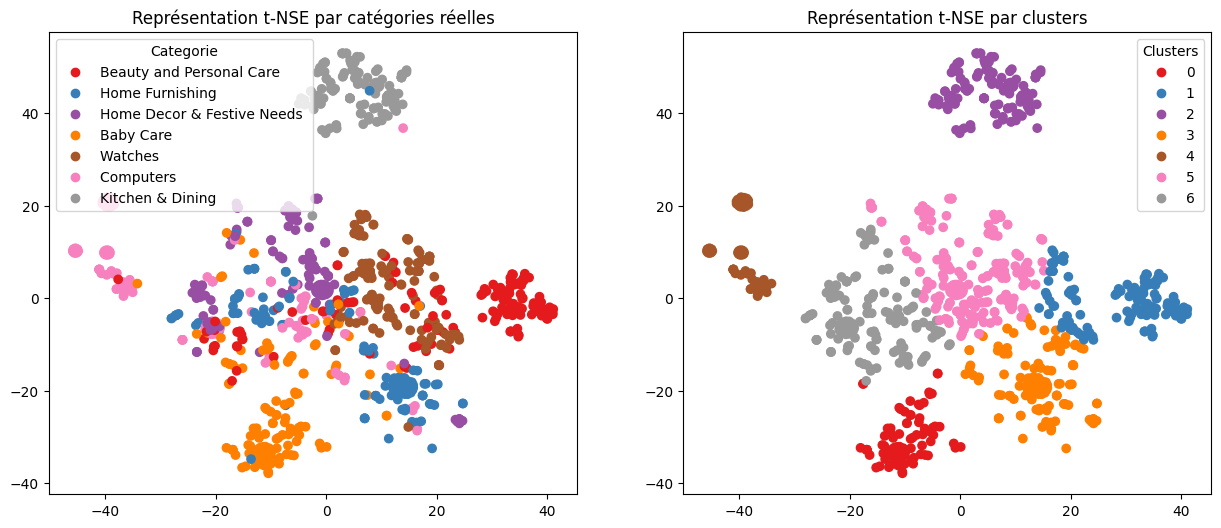

ARI :  0.409


In [290]:
comparatif_t_nse_clusters(
    X_tsne_comptage, labels_reel, cls_labels_comptage, ARI_comptage)

Nous remarquons que les catégories réelles et les catégories issues du clustering ont des similitudes sans pour autant être parfaitements séparées.Cela néanmoins penser qu'une classification automatique est possible. 

Cette intuition est conforté par le score ARI > 0.4 qui est convenable pour espérer une classification automatique de qualité convenable en utilisant les données textuelles et en améliorant le traitement des données.

### <span style='background:black'>b/ tf-idf</span>

##### **Création matrice**

Nous créons un bag of words avec la méthode **TfidfVectorizer** de la librairie **sklearn** sur les tokens contenus dans la feature "description".

Nous appliquons des methodes de nettoyage supplémentaires : seuil de fréquence de mots et normalisation des mots.

In [291]:
# Créer TfidfVectorizer avec seuil de fréquence et normalisation des mots
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95, lowercase=True)

# fit TfidfVectorizer avec le vocab et transform en matrice de termes-document
X_tf_idf = vectorizer.fit_transform(df_text_eng["description"])

# Matrice avec tout le vocab du corpus
vocab = pd.DataFrame(vectorizer.get_feature_names_out(), columns=["token"])

# Matrice de termes-document sous forme d'un df
X_tf_idf_df = pd.DataFrame(
    X_tf_idf.toarray(), columns=vocab["token"])
display(X_tf_idf_df)

token,abstract,accessory,actual,adapter,additional,adorable,affordable,age,also,aluminium,antique,apple,apply,area,aroma,around,art,assured,attractive,authentication,available,baby,bag,base,bath,...,used,video,vinyl,voltage,wall,wardrobe,warm,warranty,wash,washable,watch,waterproof,way,wear,wide,wireless,without,woman,wood,wooden,work,would,year,yellow,yet
0,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.63,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.11,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.00,0.22,0.0
2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.14,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.05,0.00,0.0
3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.06,0.08,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.06,0.00,0.00,0.0,0.00,0.0,0.0,0.05,0.00,0.06,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.29,0.1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.17,0.00,0.00,0.0,0.71,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1046,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.0,0.57,0.0,0.0,0.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.15,0.21,0.0,0.40,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.14,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1047,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1048,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.00,0.00,0.40,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0


##### **Réduction dimension**

ACP

Nous réduisons la dimension de notre matrice avec une ACP pour améliorer l'apprentissage de notre modèle et diminuer les couts de calcul.

Nous conservons 99% de la variance.

In [292]:
# Affficher la taille de la matrice de tf_idf
print("Dimension du df tf-idf:", X_tf_idf_df.shape)

# ACP
pca = decomposition.PCA(n_components=0.99)
X_tf_idf_acp_df = pca.fit_transform(X_tf_idf_df)
print("Dimension du df apres la PCA:", X_tf_idf_acp_df.shape)

Dimension du df tf-idf: (1050, 378)
Dimension du df apres la PCA: (1050, 250)


99% de la variance est conservée en réduisant le df de 378 features => 250 features. 

t-SNE

Nous réduisons la dimension de notre df apres l'ACP avec un t-SNE pour afficher les 2 premières composantes principales.

In [293]:
# Calculer t-NSE et clusters
ARI_tf_idf, X_tsne_tf_idf, cls_labels_tf_idf = calcul_t_nse_et_clusters(
    X_tf_idf_acp_df,
    labels_reel
    )

Temps t-NSE + cluster :  4.0 sec


**Comparaison catégories réelles Vs catégories clustering**

Nous affichons les 2 dimensions du t-SNE avec les vraies catégories et avec les catégories issues du clustering. Egalement, nous affichons le score de similarité entre les 2 catégories avec l'ARI.

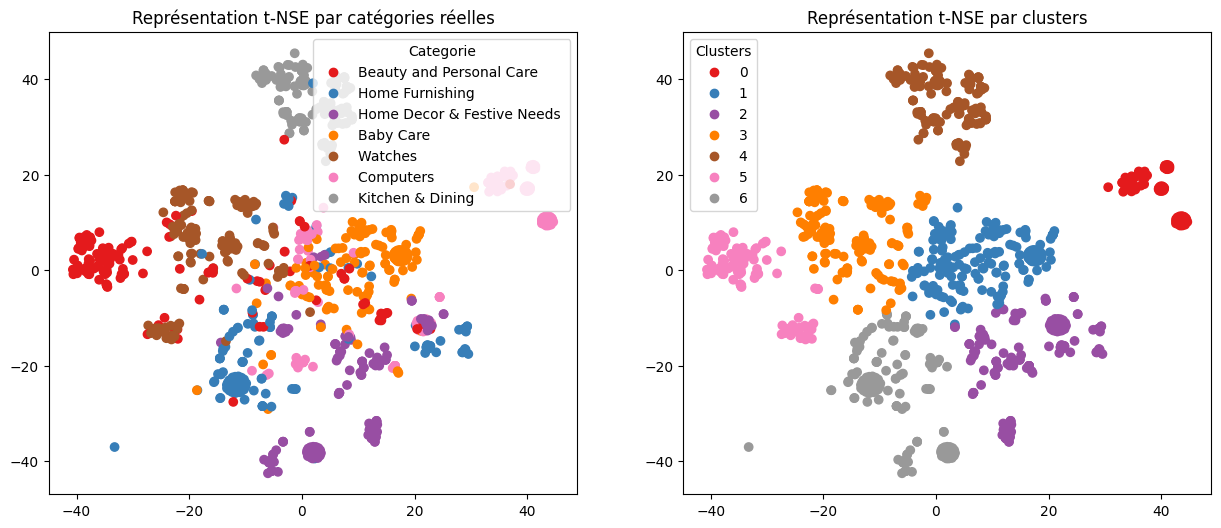

ARI :  0.49


In [316]:
comparatif_t_nse_clusters(
    X_tsne_tf_idf, labels_reel, cls_labels_tf_idf, ARI_tf_idf)

Ici aussi, nous remarquons que les catégories réelles et les catégories issues du clustering ont des similitudes sans pour autant être parfaitements séparées. Le score ARI est meilleur que pour le comptage simple de mots. Cela néanmoins penser qu'une classification automatique avec le tf-idf est possible.

## <span style='background:green'>2/ Word2Vec</span>

**Création du modèle**

Nous déterminons les paramètres de notre modèle Word2Vec.

Nous affichons un document témoin pour vérifier les prétraitements appliqués.

In [295]:
# --- PARAMETRES MODELE WORD2VEC ---
# Taille des vecteurs de mots
w2v_size = 300

# Taille de la fenetre contextuelle
w2v_window = 5

# Nombre d'occurence minimum de mots
w2v_min_count = 1

# Nombre de fois où l'on parcourt le corpus
w2v_epochs = 100

# Nombre de caractere maximum dans un mot
maxlen = 24

# Affichage du document temoin pour observer les modifications
print("-" * 30, "df_text['description']", "-" * 30)
print(df_text['description'], "\n")

sentences = df_text['description'].to_list()
print("-" * 30, "sentences", "-" * 30)
print(sentences[numero_document_temoin], "\n")

sentences = [gensim.utils.simple_preprocess(text) for text in sentences]
print("-" * 30, "sentences", "-" * 30)
print(sentences[numero_document_temoin])

------------------------------ df_text['description'] ------------------------------
0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object 

------------------------------ sentences ------------------------------
Maserati Time R8851116001 Analog Watch  - For Boys - Buy Maserati Time R8851116001 Analog Watch  - For Boys  R8851116001 Online at Rs.24400 in India Only at

Nous créons et entrainons notre modèle Word2Vec avec la librairie **gensim** afin de récupérer les vecteurs de mots.

In [296]:
# Creation du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(
    min_count=w2v_min_count,
    window=w2v_window,
    vector_size=w2v_size,
    seed=42,
    workers=multiprocessing.cpu_count())

# Construire le vocabulaire
w2v_model.build_vocab(sentences)

# Entraîner le modèle
w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)

# Recupération des vecteurs de mots du modele entraine
model_vectors = w2v_model.wv

# Recuperation de la liste des mots du vocabulaire
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...


Vocabulary size: 5192
Word2Vec trained


Nous préparons notre corpus pour l'embedding avec un tokenizer.

In [297]:
# Création du tokenizer et fit sur les sentences
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

# Conversion des phrases en séquences de nombres
# (uniformisation de la longueur avec ajout de 0 si neccessaire)
x_sentences = pad_sequences(
    tokenizer.texts_to_sequences(sentences),
    maxlen=maxlen,
    padding='post')

# Nombre de mots uniques dans les phrases
word_index = tokenizer.word_index
vocab_taille = len(word_index) + 1
print("Number of unique words: %i" % vocab_taille)

Fit Tokenizer ...
Number of unique words: 5193


**Création de la matrice d'embedding**

Nous créons la matrice d'embedding à partir des mots pré-traiter par le tokenizer et des vecteurs de mot issus de notre modèle Word2Vec.

In [298]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")

# Création matrice d'embedding vide
# (ligne = nombre de mots du vocab / colonne = dimension des vecteurs de mots)
embedding_matrix = np.zeros((vocab_taille, w2v_size))

# initialisation des itérateurs
i = 0
j = 0

# POUR chaque mot du vocabulaire
for word, idx in word_index.items():
    i += 1

    # SI mot présent dans vocab Word2Vec ALORS recuperation du vecteur du mot
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]

        # SI vecteur de mot pas null ALORS ajout dans matrice d'embedding
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

# Ratio de mots présents dans le vocab Word2Vec
word_rate = np.round(j/i, 2)

# Affichage des résultats
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (5193, 300)


**Création du modèle d'embedding**

Création du modèle d'embedding avec la librairie **keras** et à partir de la matrice d'embedding.

In [299]:
# 1ere couche d'entree du modele (def par nombre_phrase et longueur_max phrase)
input = Input(shape=(len(x_sentences), maxlen), dtype='float64')

# 2eme couche d'entree du modele (def par longueur_max phrase)
word_input = Input(shape=(maxlen,), dtype='float64')

# Couche d'embedding du modele
# (input : taille_vocab (longueur max des phrases) => taille_vecteur_mot /
# poids initialisés avec matrice d'embedding )
word_embedding = Embedding(
    input_dim=vocab_taille,
    output_dim=w2v_size,
    weights=[embedding_matrix],
    input_length=maxlen)(word_input)

# Couche de pooling globale moyenne (reduction de la dimension)
word_vec = GlobalAveragePooling1D()(word_embedding)

# Creation du modele
embed_model = Model([word_input], word_vec)

# Affichage du modele
embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 24, 300)           1557900   
                                                                 
 global_average_pooling1d_2  (None, 300)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
Total params: 1557900 (5.94 MB)
Trainable params: 1557900 (5.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


La couche d'entrée du modele attend des vecteurs de 24 dimensions. 

La couche d'embedding du modele chaque entier d'entrée du modele en un vecteur dense de 300 dimensions. Il y a 1_557_900 parametres dans cette couche car c'est le produit du nombre de mot unique dans le vocabulaire (5_193) et le nombre de dimensions de l'embedding (300).

La couche de pooling globale moyen du modele calcule un vecteur de 300 dimensions pour chaque exemple en prenant la moyenne des vecteurs de chaque mot.

**Execution du modèle**

Nous transformons les documents en vecteurs avec le modèle d'embedding.

In [300]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 300)

Nous obtenons une matrice composée de vecteur numérique de 300 dimensions pour chacun des 1_050 documents.

**Réduction dimension**

Nous réduisons la dimension de notre embedding apres l'ACP avec un t-SNE pour afficher les 2 premières composantes principales.

In [301]:
# Calculer t-NSE et clusters
ARI_word2vec, X_tsne_word2vec, cls_labels_word2vec = calcul_t_nse_et_clusters(
    embeddings,
    labels_reel
    )

Temps t-NSE + cluster :  3.0 sec


**Comparaison catégories réelles Vs catégories clustering**

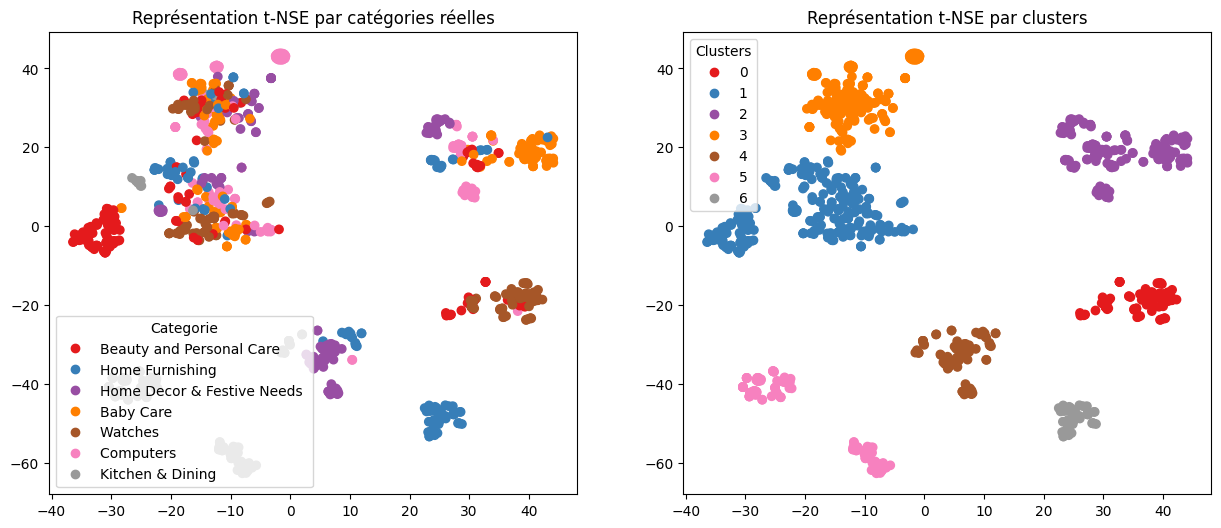

ARI :  0.239


In [302]:
comparatif_t_nse_clusters(
    X_tsne_word2vec,
    labels_reel,
    cls_labels_word2vec,
    ARI_word2vec
    )

La comparaison des catégories réelles et des catégories issues du clustering ne laisse pas penser qu'une classification automatique efficace est possible avec le Word2Vec. Le score ARI est faible (< 0.3).

## <span style='background:green'>3/ BERT</span>

### <span style='background:black'>a/ BERT HuggingFace</span>

Nous parametrons notre modèle BERT avec la librairie **transformers** de HuggingFace.

Nous utilisons le modèle 'bert-base-uncased' qui est un modèle pré-entrainé sur un large corpus de texte en anglais et qui n'est pas sensible à la casse. Il est capable de capturer une grande variété de nuances lingistiques.

Une autre approche serait d'utiliser le modèle 'bert-large-uncased' qui est plus performant mais qui est plus long à entrainer.

In [303]:
# Paramètres (longueur max des phrases et taille de lot)
max_length = 64
batch_size = 10

# Chargement du modèle Bert (pre-entraine avec des lettres minuscules)
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)

# Conversion des documents en list
sentences = df_text['description'].to_list()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Nous créons les features à partir d'un modèle BERT (HuggingFace) avec notre corpus. 

In [304]:
# Création des features
features_bert_hf, last_hidden_states_tot = feature_BERT_fct(
    model,
    model_type,
    sentences,
    max_length,
    batch_size,
    mode='HF'
    )

1/1 [==============================] - 1s 516ms/step
temps traitement :  71.0


Comparaison catégories réelles Vs catégories clustering

In [305]:
ARI_bert_hf, X_tsne_bert_hf, cls_labels_bert_hf = calcul_t_nse_et_clusters(
    features_bert_hf,
    labels_reel
    )

Temps t-NSE + cluster :  3.0 sec


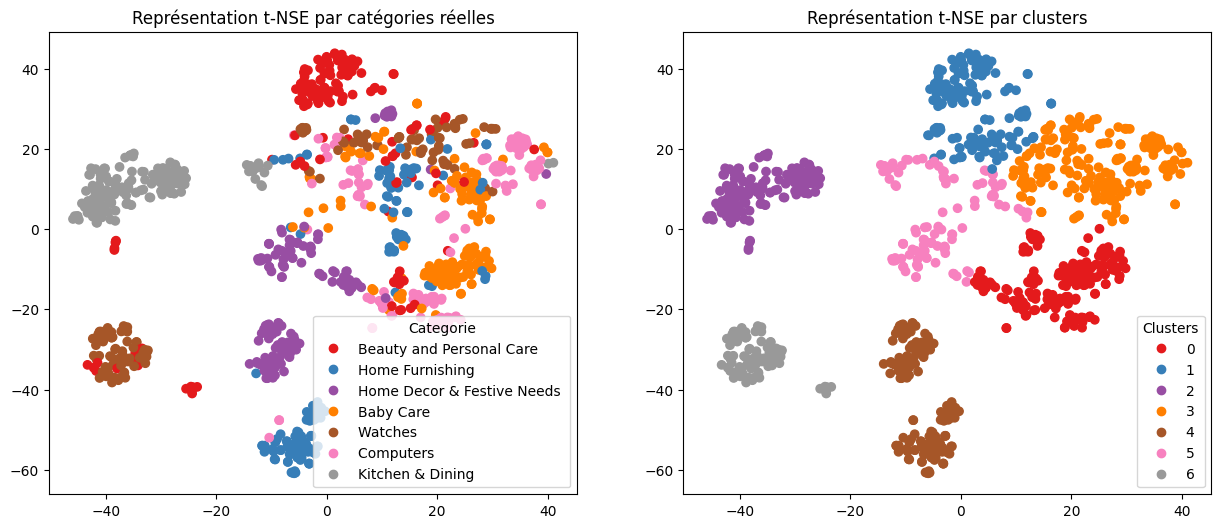

ARI :  0.307


In [306]:
comparatif_t_nse_clusters(
    X_tsne_bert_hf,
    labels_reel,
    cls_labels_bert_hf,
    ARI_bert_hf
    )

La comparaison des catégories réelles et des catégories issues du clustering ne laisse pas penser qu'une classification automatique efficace est possible avec le BERT Hugging Face. Le score ARI est faible (< 0.4).

### <span style='background:black'>b/ BERT hub Tensorflow</span>

Nous réalisons la même approche avec le modèle BERT de Tensorflow hub. Ce modèle est pre-entraine en anglais non sensible a la casse. Il est composé de 12 couches et les poids seront mis à jour lors de l'entrainement

In [307]:
# Chargement du modèle Bert TF Hub
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)
model = bert_layer

Nous créons les features à partir d'un modèle BERT (Tensorflow Hub) avec notre corpus. 

In [308]:
# creation des features
features_bert_tfhub, last_hidden_states_tot = feature_BERT_fct(
    model,
    model_type,
    sentences,
    max_length,
    batch_size,
    mode='TFhub'
    )

temps traitement :  67.0


Comparaison catégories réelles Vs catégories clustering

In [309]:
# Calculer t-NSE et clusters
ARI_bert_tfhub, X_tsne_bert_tfhub, cls_labels_bert_tfhub = \
    calcul_t_nse_et_clusters(
        features_bert_tfhub,
        labels_reel
        )

Temps t-NSE + cluster :  4.0 sec


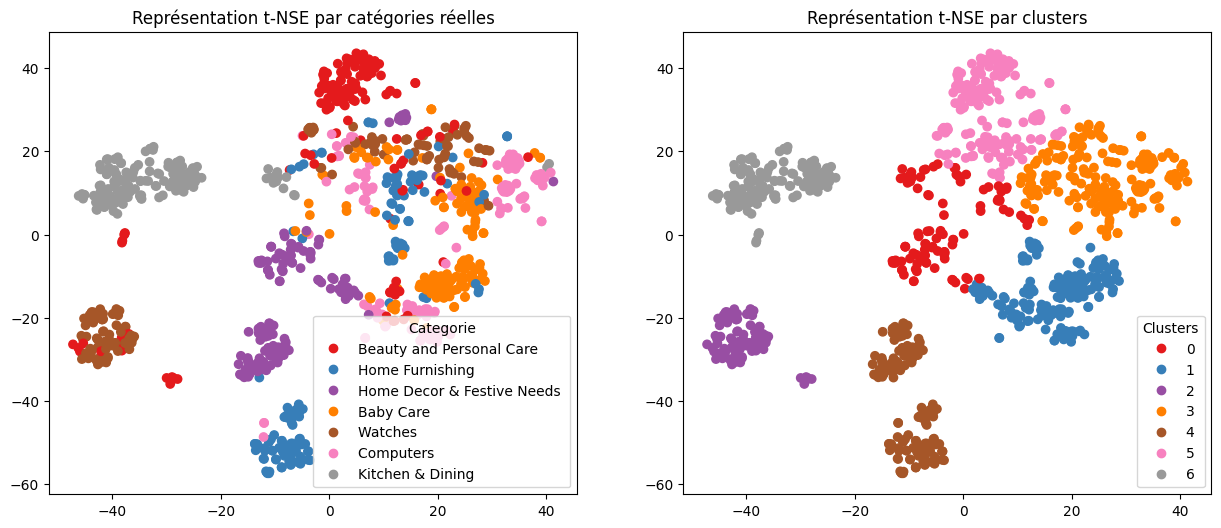

ARI :  0.315


In [310]:
comparatif_t_nse_clusters(
    X_tsne_bert_tfhub,
    labels_reel,
    cls_labels_bert_tfhub,
    ARI_bert_tfhub
    )

La comparaison des catégories réelles et des catégories issues du clustering ne laisse pas penser qu'une classification automatique efficace est possible avec le BERT hub Tensorflow. Le score ARI est faible (< 0.4).

## <span style='background:green'>4/ USE</span>

Le modèle USE (Universal Sentence Encoder) est un modèle de transfert d'apprentissage dévoloppé par Google qui permet de créer des embeddings de phrases. Il est pré-entrainé sur un large corpus de texte en anglais et n'est pas sensible à la casse.

Il existe 2 versions du modèle USE :
- **USE** : modèle de base
- **USE-Large** : modèle plus performant mais plus long à entrainer

Nous chargeons le modèle USE de base pour avoir un aperçu de la performance de ce modèle sans demander trop de ressources de calcul.

In [311]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

Nous créons les features à partir d'un modèle USE avec notre corpus. 

In [312]:
features_use = feature_USE_fct(sentences, batch_size, embed)

temps traitement USE :  1.0


Comparaison catégories réelles Vs catégories clustering

In [313]:
# Calculer t-NSE et clusters
ARI_use, X_tsne_use, cls_labels_use = \
    calcul_t_nse_et_clusters(
        features_use,
        labels_reel
        )

Temps t-NSE + cluster :  4.0 sec


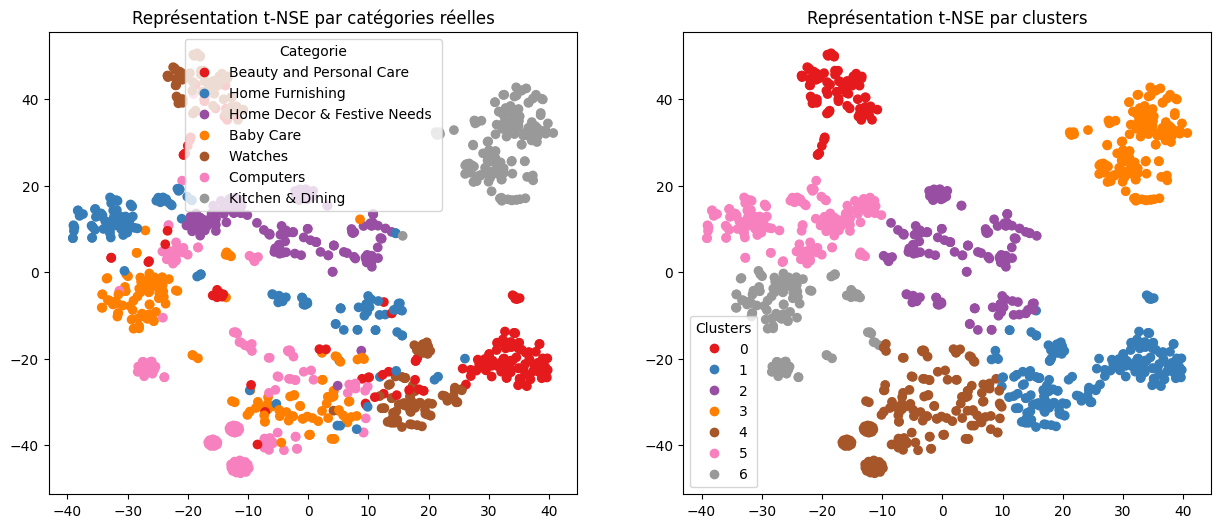

ARI :  0.445


In [314]:
comparatif_t_nse_clusters(
    X_tsne_use,
    labels_reel,
    cls_labels_use,
    ARI_use
    )

Nous remarquons que les catégories réelles et les catégories issues du clustering ont des similitudes sans pour autant être parfaitements séparées. Le score ARI est correct (> 0.4) mais il reste inferieur à celui obtenu avec le bag of word en utilisant tf-idf.

# <span style='background:blue'>Conclusion</span>

L'élaboration d'un moteur de classification automatique de produits à partir de leur description textuelle nous parait possible. En effet, nous avons obtenu des scores de similarité entre les catégories réelles et les catégories issues du clustering qui sont corrects (> 0.4) avec différentes méthodes de traitement des données textuelles. Nous opterions pour le bag of word avec tf-idf qui est la méthode qui a donné les meilleurs résultats.

In [315]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée totale pour faire tourner le notebook : 4 minute(s) 15 seconde(s)
